[1] C. Avendano and J. M. Jot, "Frequency Domain Techniques for Stereo to Multichannel Upmix" Audio Engineering Society Conference: 22nd International Conference: Virtual, Synthetic, and Entertainment Audio, Jun 20

assumed there's $N$ sources, here's the multiple channel convolutional room reverberation:

$$
x_i = \sum_{j=1}^{N}s_{ij}(t) * h_{ij}(t) + n(t)
$$

and room reverberation can be denoted into direct and reflection coefficients.
$$
h_j(t) = d_j(t) + r_j(t)
$$


$i$ denote channel index and $j$ denote source index. $d$ denotes direct room impluse response and $r$ denotes reflection impulse response.

$$
x_i = \sum_{j=1}^{N}s_{j}(t) * d_{ij}(t) + \sum_{j=1}^{N}s_{j}(t) * r_{ij}(t) + n_i(t) \tag1
$$

Let us first denote the STFT’s of the channel signals , $x_i(t)$ as $X_i(m,k)$ , where $m$ is the time index and $k$ is the frequency index. We define the following statistical quantities:

$$
\phi_{ij}(k) = E\left\{ X_i(m,k)X_j^*(m,k) \right\} \tag2
$$

where $E$ is the expectation operator with respect to $m$ and the superscript 3 denotes complex conjugation. Audio
signals are in general non-stationary. For this reason the statistics will change with time. To track the changes of
the signal and to be able to implement a causal system we introduce a forgetting factor $\lambda$ in the computation of the cross-correlation functions in $(2)$. Thus in practice these statistics are computed as short-time functions:

$$
\phi_{ij}(m,k) = (1-\lambda)\phi_{ij}(m-1,k) + \lambda X_i(m,k) X_j^*(m,k) \tag3
$$

Using these statistical quantities we define the interchannel short-time coherence function as:

$$
\phi(m,k) = \frac{\phi_{12}(m,k)}{\sqrt{\phi_{11}(m,k)\phi_{22}(m,k)}} \tag4
$$

In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython

In [2]:
def c_add(m1, p1, m2, p2):
    real      = np.multiply(m1, np.cos(p1)) + np.multiply(m2, np.cos(p2))
    imaginary = np.multiply(m1, np.sin(p1)) + np.multiply(m2, np.sin(p2))
    magnitude = np.sqrt(np.multiply(real, real)) + np.multiply(imaginary, imaginary)
    phase     = np.arctan(np.divide(imaginary, real))
    return magnitude, phase

In [3]:
def coherence(mX, pX, mY, pY, m, p, lamda=0.1):
    m_11, p_11 = c_add( (1-lamda) * m[0], p[0], lamda * np.multiply(mX, mX) , 0 )
    m_22, p_22 = c_add( (1-lamda) * m[1], p[1], lamda * np.multiply(mY, mY) , 0 )
    m_12, p_12 = c_add( (1-lamda) * m[2], p[2], lamda * np.multiply(mX, mY) , (pX - pY) )

    return np.transpose(np.c_[m_11, m_22, m_12]), np.transpose(np.c_[p_11, p_22, p_12])

In [4]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

In [5]:
# Frame Size
M = 2048

# FFT Size
N = 2048

# Hop Size
H = 512

# Window
W = signal.get_window("hann", M)

# u0 and u1 determine range of output
u1 = 1.0 

# determines the floor of the function
u0 = 0.001 

# controls the slope of the function
sigma = 8 

# sets the threshold
phi0 = 0.5

# forgetting factor
lamda = 0.1 

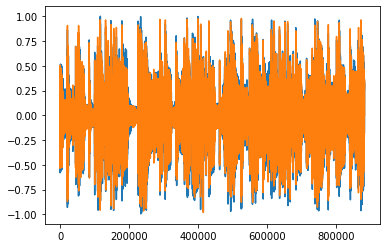

In [6]:
file = wavio.read("Protection.wav")
fixed_data0 = file.data[:, 0]
fixed_data1 = file.data[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

start = 20 * file.rate
end = 40 * file.rate
data0 = data0[start:end]
data1 = data1[start:end]

plt.plot(data0)
plt.plot(data1)
plt.show()

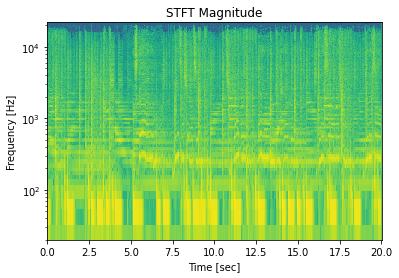

In [7]:
f, t, Zxx = signal.stft(data0, file.rate, nperseg=2048)
amplitude = 20 * np.log10(np.abs(Zxx))
plt.pcolormesh(t, f, amplitude)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(20, 22000)
plt.show()